 Header

In [2]:
# 🤖 LLM Preprocessing Example
# Compact version — no external imports needed

import pandas as pd
import numpy as np
import json


🇬🇧Local implementations (replaces `agrupa_dicionario`)
🇧🇷 locais (substitui agrupa_dicionario)

In [3]:
def _agg_axis(df, cols, agg_func):
    if not cols:
        return pd.Series([0]*len(df), index=df.index)
    if agg_func == 'sum': return df[cols].sum(axis=1)
    if agg_func == 'mean': return df[cols].mean(axis=1)
    if agg_func == 'max': return df[cols].max(axis=1)
    if agg_func == 'count': return df[cols].count(axis=1)
    try: return df[cols].agg(agg_func, axis=1)
    except: return df[cols].sum(axis=1)

def build_grouped_features(df, mapping, agg_func='sum'):
    df = df.copy()
    groups = list({mapping[c] for c in df.columns if c in mapping})
    result = pd.DataFrame(index=df.index)
    for g in groups:
        cols = [c for c, grp in mapping.items() if grp == g and c in df.columns]
        result[g] = _agg_axis(df, cols, agg_func)
    return result

def row_to_llm_features(grouped_df, row_id):
    s = grouped_df.loc[row_id]
    return {k: (None if pd.isna(v) else float(v)) for k,v in s.items()}

def create_llm_prompt_template(features, user_id, task):
    return f"""User: {user_id}
Features:
{json.dumps(features, indent=2)}

Task:
{task}
"""


🇬🇧 Data simulation

🇧🇷 Simulação dos dados

In [4]:
np.random.seed(42)
users = [f"User_{i}" for i in range(1, 11)]

user_data = pd.DataFrame({
    "views_electronics":  np.random.randint(10,100,10),
    "views_clothing":     np.random.randint(10,100,10),
    "views_home":         np.random.randint(10,100,10),

    "clicks_electronics": np.random.randint(5,30,10),
    "clicks_clothing":    np.random.randint(5,30,10),
    "clicks_home":        np.random.randint(5,30,10),

    "purchases_electronics": np.random.randint(0,5,10),
    "purchases_clothing":    np.random.randint(0,5,10),
    "purchases_home":        np.random.randint(0,5,10),
}, index=users)

user_data


,views_electronics,views_clothing,views_home,clicks_electronics,clicks_clothing,clicks_home,purchases_electronics,purchases_clothing,purchases_home
User_1,61,33,69,20,23,13,0,3,1
User_2,24,12,30,19,11,25,3,1,0
User_3,81,31,42,19,25,6,1,1,3
User_4,70,62,85,23,13,24,3,3,3
User_5,30,11,67,16,11,19,1,3,3
User_6,92,97,31,27,22,11,1,0,4
User_7,96,39,98,24,8,16,3,4,0
User_8,84,47,58,29,29,12,4,4,4
User_9,84,11,68,7,18,19,1,1,4
User_10,97,73,51,9,22,7,1,4,0


🇬🇧 Mapping + Grouping + Metrics

🇧🇷 Mapping + Agrupamento + Métricas

In [5]:
action_mapping = {
    "views_electronics":"views", "views_clothing":"views", "views_home":"views",
    "clicks_electronics":"clicks","clicks_clothing":"clicks","clicks_home":"clicks",
    "purchases_electronics":"purchases","purchases_clothing":"purchases","purchases_home":"purchases"
}

action_grouped = build_grouped_features(user_data, action_mapping)

action_grouped["click_rate"] = (action_grouped["clicks"] / action_grouped["views"] * 100).round(2)
action_grouped["purchase_rate"] = (action_grouped["purchases"] / action_grouped["clicks"] * 100).round(2)
action_grouped["overall_conversion"] = (action_grouped["purchases"] / action_grouped["views"] * 100).round(2)

action_grouped


,clicks,purchases,views,click_rate,purchase_rate,overall_conversion
User_1,56,4,163,34.36,7.14,2.45
User_2,55,4,66,83.33,7.27,6.06
User_3,50,5,154,32.47,10.00,3.25
User_4,60,9,217,27.65,15.00,4.15
User_5,46,7,108,42.59,15.22,6.48
User_6,60,5,220,27.27,8.33,2.27
User_7,48,7,233,20.60,14.58,3.00
User_8,70,12,189,37.04,17.14,6.35
User_9,44,6,163,26.99,13.64,3.68
User_10,38,5,221,17.19,13.16,2.26



🇬🇧 Prompt generation + example

🇧🇷 Geração de prompt + exemplo

In [6]:
user_id = "User_1"
features = row_to_llm_features(action_grouped, user_id)

prompt = create_llm_prompt_template(
    features=features,
    user_id=user_id,
    task="""Based on this user's behavior:
1. Recommend 3 product categories.
2. Suggest a marketing message.
3. Estimate intent level.
4. Suggest next best action."""
)

print(prompt)


User: User_1
Features:
{
  "clicks": 56.0,
  "purchases": 4.0,
  "views": 163.0,
  "click_rate": 34.36,
  "purchase_rate": 7.14,
  "overall_conversion": 2.45
}

Task:
Based on this user's behavior:
1. Recommend 3 product categories.
2. Suggest a marketing message.
3. Estimate intent level.
4. Suggest next best action.



🇬🇧 Export all

🇧🇷 Exportar tudo

In [7]:
output = {
    "metadata": {
        "total_users": len(user_data),
        "feature_groups": list(action_grouped.columns),
        "generated_at": pd.Timestamp.now().isoformat()
    },
    "user_features": action_grouped.to_dict(orient="index")
}

with open("llm_features.json", "w") as f:
    json.dump(output, f, indent=2)

print("✓ Exported llm_features.json")


✓ Exported llm_features.json


Visualize User Behavior Patterns

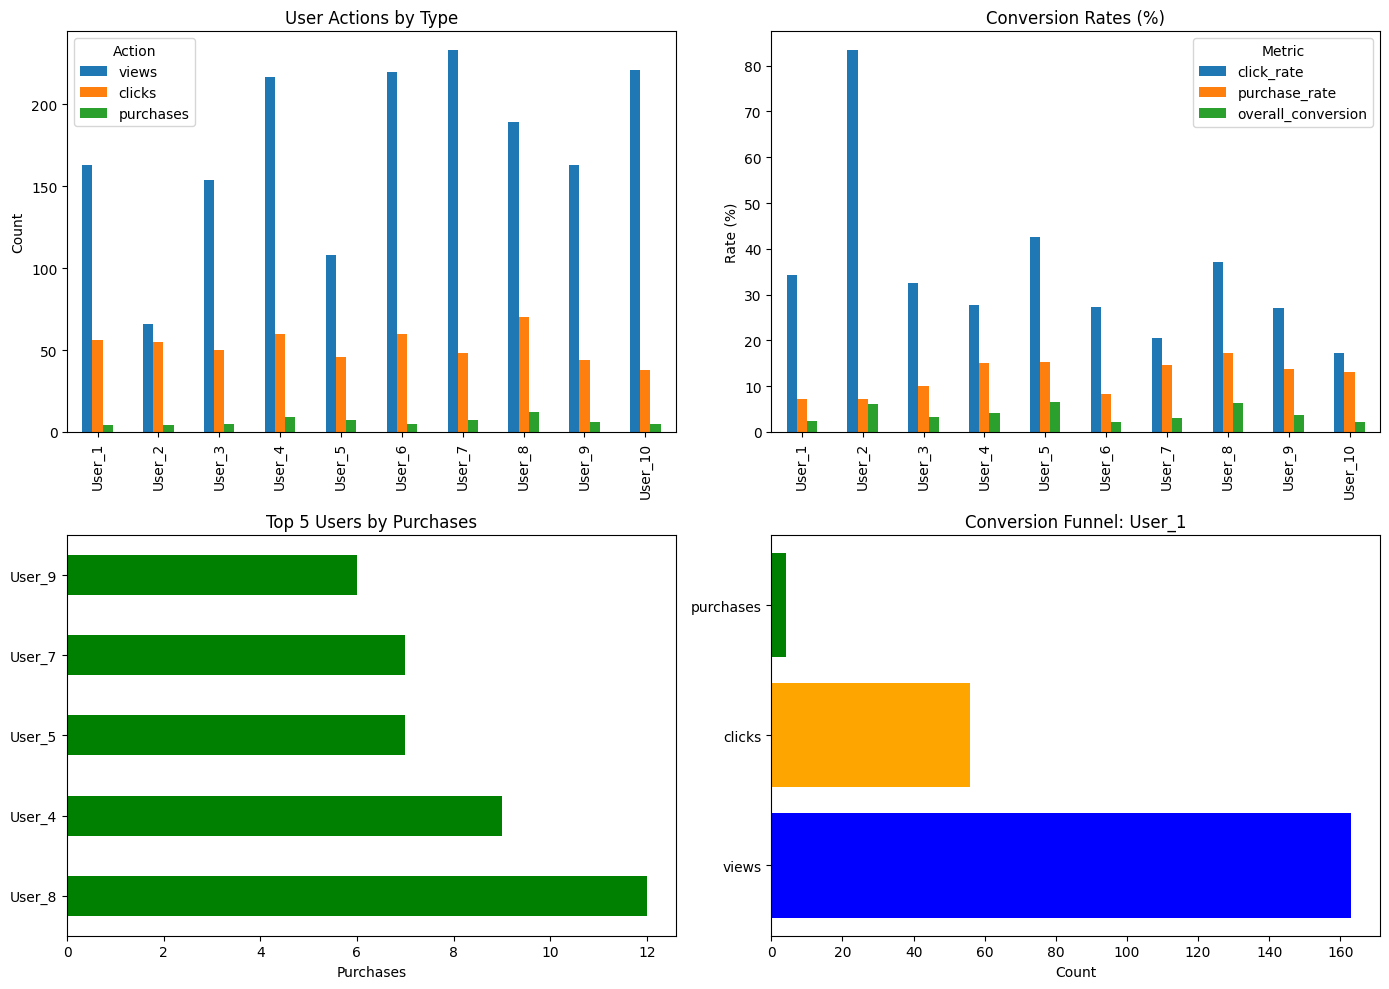

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14,10))

# 1️⃣ Action totals
action_grouped[['views','clicks','purchases']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('User Actions by Type')
axes[0,0].set_ylabel('Count')
axes[0,0].legend(title='Action')

# 2️⃣ Conversion rates
action_grouped[['click_rate','purchase_rate','overall_conversion']].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Conversion Rates (%)')
axes[0,1].set_ylabel('Rate (%)')
axes[0,1].legend(title='Metric')

# 3️⃣ Top users by purchases
top_buyers = action_grouped.nlargest(5,'purchases')
top_buyers['purchases'].plot(kind='barh', ax=axes[1,0], color='green')
axes[1,0].set_title('Top 5 Users by Purchases')
axes[1,0].set_xlabel('Purchases')

# 4️⃣ Conversion funnel for User_1
funnel_data = action_grouped.loc['User_1', ['views','clicks','purchases']]
axes[1,1].barh(funnel_data.index, funnel_data.values, color=['blue','orange','green'])
axes[1,1].set_title('Conversion Funnel: User_1')
axes[1,1].set_xlabel('Count')

plt.tight_layout()
plt.show()


🇬🇧  This chart provides:

* Totals of actions by type (views, clicks, purchases)
* Conversion rates (% clicks/views, % purchases/clicks, % purchases/views)
* Top 5 users by purchases
* Conversion funnel for User_1


### 🇧🇷 Esse gráfico fornece:

Totais de ações por tipo (views, clicks, purchases)

Taxas de conversão (% clicks/views, % purchases/clicks, % purchases/views)

Top 5 usuários por compras

Funil de conversão do User_1